In [1]:
import itertools
import json
import operator
import os
from pathlib import Path
from pprint import pprint
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

## Load data and preprocess

### Metadata

In [2]:
# Map from test suite tag to high-level circuit.
circuits = {
    "Licensing": ["npi", "reflexive"],
    "Long-Distance Dependencies": ["fgd", "embed", "number", "comparison"],
    "Garden-Path Effects": ["gardenpath", "npz", "mvrr"],
    "Gross Syntactic State": ["subordination", "nn"],
    "Center Embedding": ["center"],
    "Transformations": ["cleft"],
}

tag_to_circuit = {tag: circuit
                  for circuit, tags in circuits.items()
                  for tag in tags}

In [3]:
# Exclusions
exclude_suite_re = re.compile(r"^fgd-embed[34]|^gardenpath")
exclude_models = ["1gram"]

### Load

In [4]:
os.chdir("..")
ppl_data_path = Path("data/raw/perplexity.csv")
test_suite_results_path = Path("data/raw/test_suite_results")

In [5]:
perplexity_df = pd.read_csv(ppl_data_path, index_col=["model", "corpus", "seed"])
perplexity_df.index.set_names("model_name", level=0, inplace=True)

results_df = pd.concat([pd.read_csv(f) for f in test_suite_results_path.glob("*.csv")])

# Split model_id into constituent parts
model_ids = results_df.model.str.split("_", expand=True).rename(columns={0: "model_name", 1: "corpus", 2: "seed"})
results_df = pd.concat([results_df, model_ids], axis=1).drop(columns=["model"])
results_df["seed"] = results_df.seed.fillna("0").astype(int)

# Exclude test suites
exclude_filter = results_df.suite.str.contains(exclude_suite_re)
print("Dropping %i results / %i suites due to exclusions:"
      % (exclude_filter.sum(), len(results_df[exclude_filter].suite.unique())))
print(" ".join(results_df[exclude_filter].suite.unique()))
results_df = results_df[~exclude_filter]

# Exclude models
exclude_filter = results_df.model_name.isin(exclude_models)
print("Dropping %i results due to dropping models:" % exclude_filter.sum(), list(results_df[exclude_filter].model_name.unique()))
results_df = results_df[~exclude_filter]

# Add tags
results_df["tag"] = results_df.suite.transform(lambda s: re.split(r"[-_0-9]", s)[0])
results_df["circuit"] = results_df.tag.map(tag_to_circuit)
tags_missing_circuit = set(results_df.tag.unique()) - set(tag_to_circuit.keys())
if tags_missing_circuit:
    print("Tags missing circuit: ", ", ".join(tags_missing_circuit))

Dropping 1302 results / 2 suites due to exclusions:
fgd-embed3 fgd-embed4
Dropping 3200 results due to dropping models: ['1gram']


In [6]:
results_df.head()

,suite,item,correct,model_name,corpus,seed,tag,circuit
0,subordination_pp-pp,0,True,grnn,,0,subordination,Gross Syntactic State
1,subordination_pp-pp,1,True,grnn,,0,subordination,Gross Syntactic State
2,subordination_pp-pp,2,True,grnn,,0,subordination,Gross Syntactic State
3,subordination_pp-pp,3,True,grnn,,0,subordination,Gross Syntactic State
4,subordination_pp-pp,4,True,grnn,,0,subordination,Gross Syntactic State


### Checks

In [7]:
# Each model--corpus--seed should have perplexity data.
ids_from_results = results_df.set_index(["model_name", "corpus", "seed"]).sort_index().index
ids_from_ppl = perplexity_df.sort_index().index
diff = set(ids_from_results) - set(ids_from_ppl)
if diff:
    print("Missing perplexity results for:")
    pprint(diff)
    #raise ValueError("Each model--corpus--seed must have perplexity data.")

Missing perplexity results for:
{('grnn', '', 0),
 ('ngram-no-rand', 'bllip-lg', 0),
 ('ngram-no-rand', 'bllip-md', 0),
 ('ngram-no-rand', 'bllip-sm', 0),
 ('ngram-no-rand', 'bllip-xs', 0),
 ('transformer-xl', '', 0)}


In [8]:
# Every model--corpus--seed should have results for all test suite items.
item_list = {model_key: set(results.suite)
             for model_key, results in results_df.groupby(["model_name", "corpus", "seed"])}
not_shared = set()
for k1, k2 in itertools.combinations(item_list.keys(), 2):
    l1, l2 = item_list[k1], item_list[k2]
    if l1 != l2:
        print("SyntaxGym test suite results for %s and %s don't match" % (k1, k2))
        print("\tIn %s but not in %s:\n\t\t%s" % (k2, k1, l2 - l1))
        print("\tIn %s but not in %s:\n\t\t%s" % (k1, k2, l1 - l2))
        print()
        
        not_shared |= l2 - l1
        not_shared |= l1 - l2

if len(not_shared) > 0:
    to_drop = results_df[results_df.suite.isin(not_shared)]
    print("Dropping these test suites (%i rows) for now. Yikes." % len(to_drop))
    results_df = results_df[~results_df.suite.isin(not_shared)]
else:
    print("OK")

OK


In [9]:
# Second sanity check: same number of results per model--corpus--seed
result_counts = results_df.groupby(["model_name", "corpus", "seed"]).item.count()
if len(result_counts.unique()) > 1:
    print("WARNING: Some model--corpus--seed combinations have more result rows than others.")
    print(result_counts)

## Main analyses

### Global settings

e.g. to maintain consistent hues across model graphs, etc.

In [11]:
model_order = sorted(set(results_df.model_name))
corpus_order = ["bllip-lg", "bllip-md", "bllip-sm", "bllip-xs"]
circuit_order = sorted([c for c in results_df.circuit.dropna().unique()])

### Data prep

In [12]:
suites_df = results_df.groupby(["model_name", "corpus", "seed", "suite"]).correct.mean().reset_index()
suites_df["tag"] = suites_df.suite.transform(lambda s: re.split(r"[-_0-9]", s)[0])
suites_df["circuit"] = suites_df.tag.map(tag_to_circuit)

In [13]:
# Join PPL and accuracy data.
joined_data = suites_df.groupby(["model_name", "corpus", "seed"]).correct.agg("mean")
joined_data = pd.DataFrame(joined_data).join(perplexity_df).reset_index()
joined_data.head()

,model_name,corpus,seed,correct,pid,test_loss,test_ppl
0,grnn,,0,0.534169,NaN,NaN,NaN
1,ngram,bllip-lg,0,0.365241,NaN,NaN,106.0919
2,ngram,bllip-md,0,0.355265,NaN,NaN,125.5826
3,ngram,bllip-sm,0,0.423931,NaN,NaN,158.5957
4,ngram,bllip-xs,0,0.287085,NaN,NaN,240.2087


In [14]:
# Join PPL and accuracy data, splitting on circuit.
joined_data_circuits = suites_df.groupby(["model_name", "corpus", "seed", "circuit"]).correct.agg("mean")
joined_data_circuits = pd.DataFrame(joined_data_circuits).reset_index().set_index(["model_name", "corpus", "seed"]).join(perplexity_df).reset_index()
joined_data_circuits.head()

,model_name,corpus,seed,circuit,correct,pid,test_loss,test_ppl
0,grnn,,0,Center Embedding,0.660714,NaN,NaN,NaN
1,grnn,,0,Garden-Path Effects,0.818452,NaN,NaN,NaN
2,grnn,,0,Gross Syntactic State,0.713043,NaN,NaN,NaN
3,grnn,,0,Licensing,0.134211,NaN,NaN,NaN
4,grnn,,0,Long-Distance Dependencies,0.654135,NaN,NaN,NaN


In [15]:
# Analyze stability to modification.
def has_modifier(ts):
    if ts.endswith(("_modifier", "_mod")):
        return True
    else:
        return None
results_df["has_modifier"] = results_df.suite.transform(has_modifier)

# Mark "non-modifier" test suites
modifier_ts = results_df[results_df.has_modifier == True].suite.unique()
no_modifier_ts = [re.sub(r"_mod(ifier)?$", "", ts) for ts in modifier_ts]
results_df.loc[results_df.suite.isin(no_modifier_ts), "has_modifier"] = False
# Store subset of test suites which have definite modifier/no-modifier marking
results_df_mod = results_df[~(results_df.has_modifier.isna())].copy()
# Get base test suite (without modifier/no-modifier marking)
results_df_mod["test_suite_base"] = results_df_mod.suite.transform(lambda ts: ts.strip("_no-modifier").strip("_modifier"))
results_df_mod.head()

,suite,item,correct,model_name,corpus,seed,tag,circuit,has_modifier,test_suite_base
84,npz_obj_mod,0,True,grnn,,0,npz,Garden-Path Effects,True,pz_obj
85,npz_obj_mod,1,True,grnn,,0,npz,Garden-Path Effects,True,pz_obj
86,npz_obj_mod,2,True,grnn,,0,npz,Garden-Path Effects,True,pz_obj
87,npz_obj_mod,3,True,grnn,,0,npz,Garden-Path Effects,True,pz_obj
88,npz_obj_mod,4,True,grnn,,0,npz,Garden-Path Effects,True,pz_obj


### `ngram` sanity checks

Text(0.5, 1.0, 'ngram test suite results, averaged across corpus size')

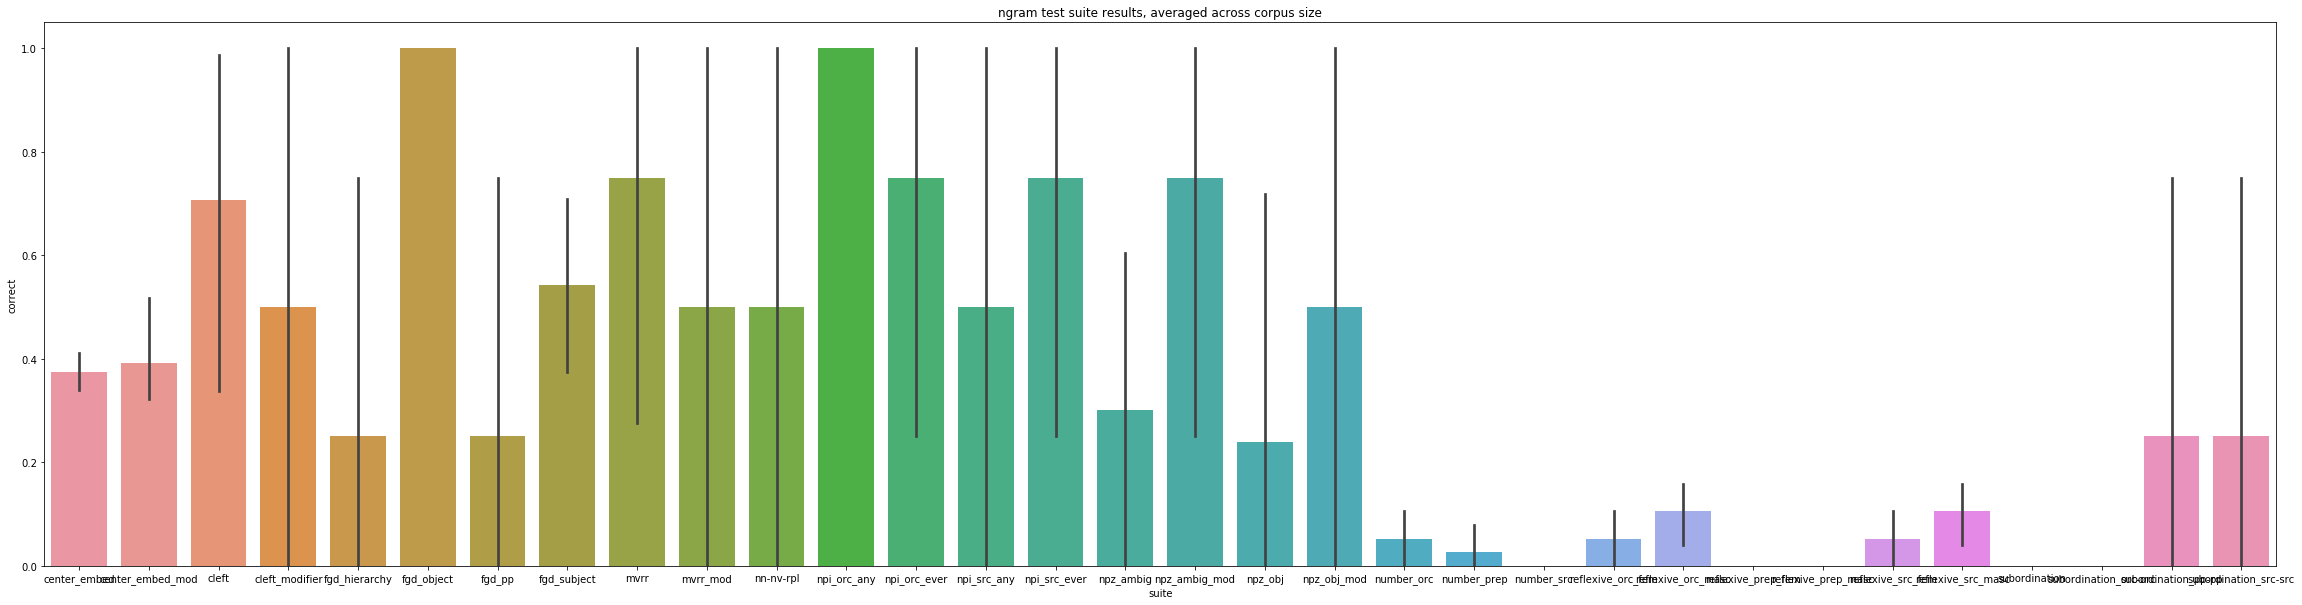

In [16]:
plt.subplots(figsize=(40, 10))
sns.barplot(data=suites_df[suites_df.model_name == "ngram"], x="suite", y="correct")
plt.title("ngram test suite results, averaged across corpus size")

Text(0.5, 1.0, 'ngram-no-rand test suite results, averaged across corpus size')

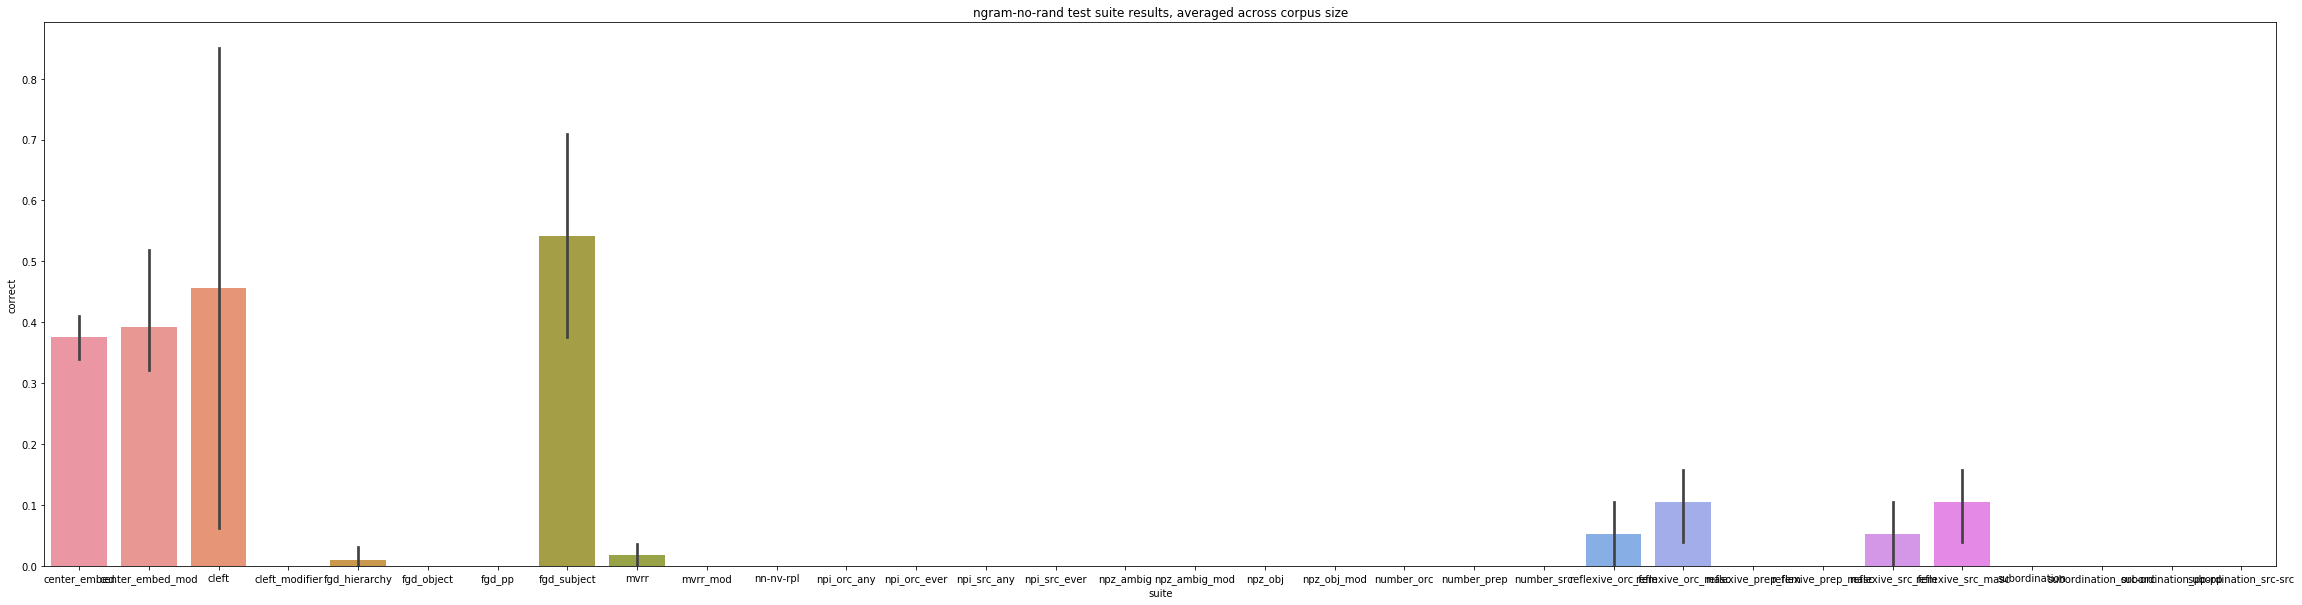

In [17]:
plt.subplots(figsize=(40, 10))
sns.barplot(data=suites_df[suites_df.model_name == "ngram-no-rand"], x="suite", y="correct")
plt.title("ngram-no-rand test suite results, averaged across corpus size")

In [18]:
if "1gram" in suites_df.model_name.unique():
    plt.subplots(figsize=(40, 10))
    sns.barplot(data=suites_df[suites_df.model_name == "1gram"], x="suite", y="correct")
    plt.title("1gram test suite results, averaged across corpus size")

### Accuracy across models

Text(0, 0.5, 'Accuracy')

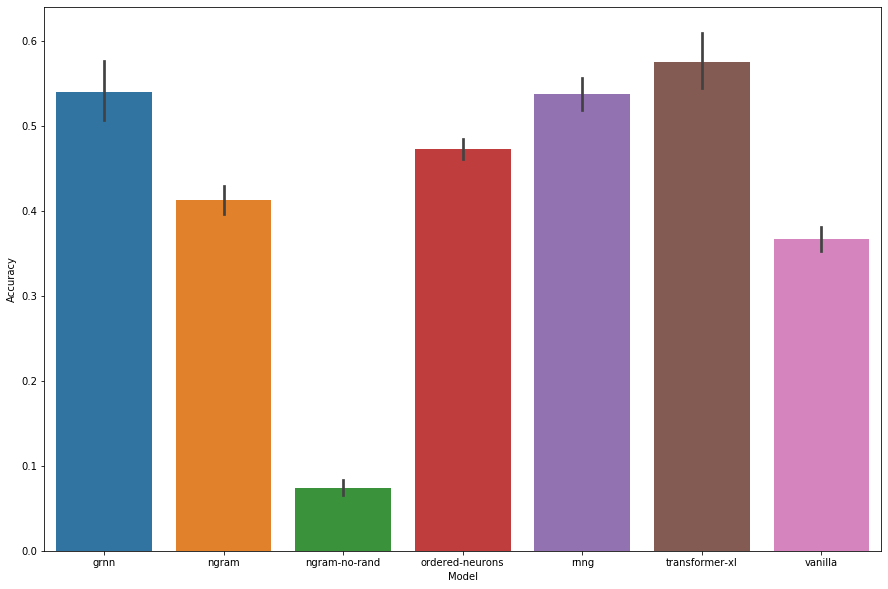

In [37]:
plt.subplots(figsize=(15, 10))
sns.barplot(data=results_df.reset_index(), x="model_name", y="correct")

plt.xlabel("Model")
plt.ylabel("Accuracy")

### Accuracy vs perplexity

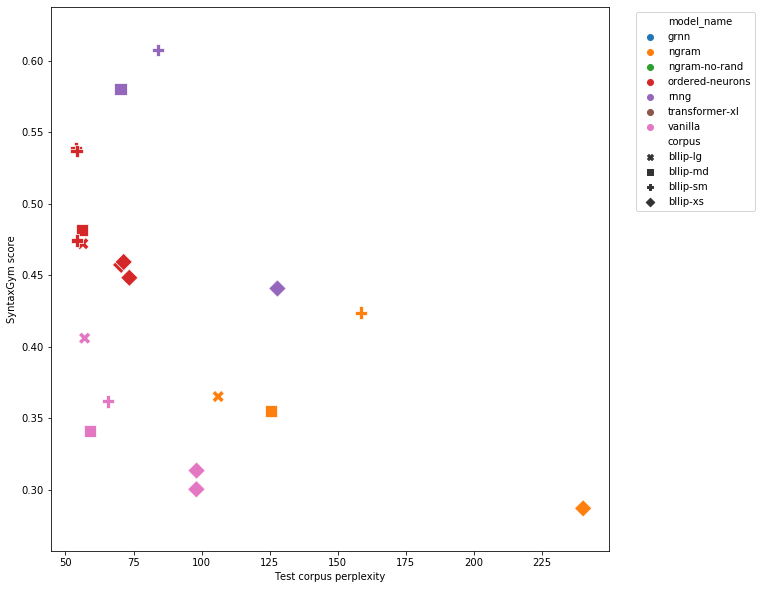

In [20]:
f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=joined_data, x="test_ppl", y="correct",
                hue="model_name", style="corpus", s=150,
                hue_order=model_order)
plt.xlabel("Test corpus perplexity")
plt.ylabel("SyntaxGym score")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

(0, 1)

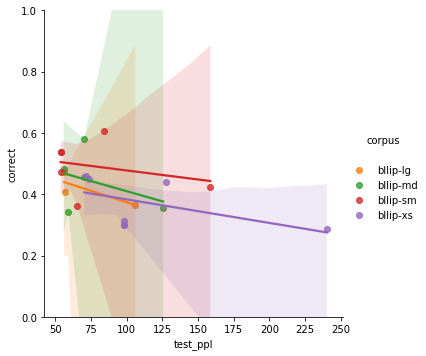

In [21]:
g = sns.lmplot(data=joined_data, x="test_ppl", y="correct",
               hue="corpus", truncate=True)
g.ax.set_ylim((0, 1))

(0, 1)

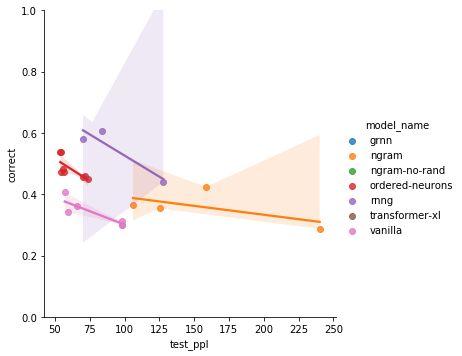

In [22]:
g = sns.lmplot(data=joined_data, x="test_ppl", y="correct",
               hue="model_name", truncate=True)
g.ax.set_ylim((0, 1))

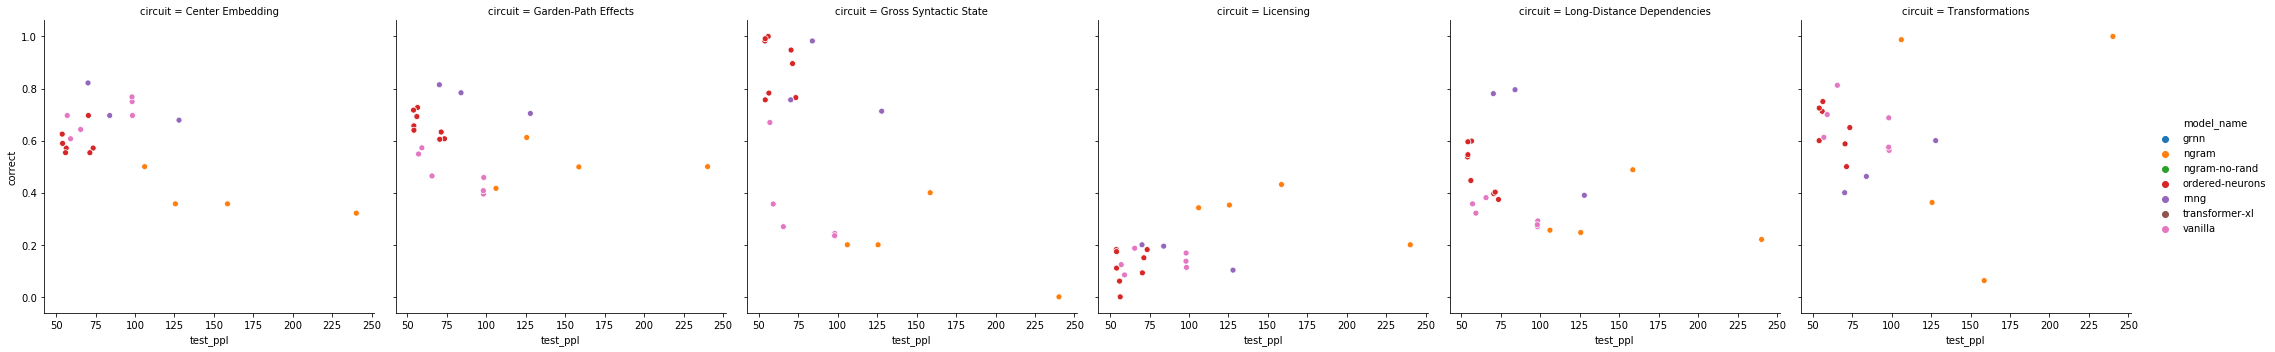

In [23]:
g = sns.FacetGrid(data=joined_data_circuits, col="circuit", height=5)
g.map(sns.scatterplot, "test_ppl", "correct", "model_name",
      hue_order=model_order)
g.add_legend()

In [24]:
joined_data_circuits.groupby(["model_name", "corpus", "circuit"]).correct.mean()

model_name  corpus    circuit                   
grnn                  Center Embedding              0.660714
                      Garden-Path Effects           0.818452
                      Gross Syntactic State         0.713043
                      Licensing                     0.134211
                      Long-Distance Dependencies    0.654135
                                                      ...   
vanilla     bllip-xs  Garden-Path Effects           0.420304
                      Gross Syntactic State         0.237681
                      Licensing                     0.139474
                      Long-Distance Dependencies    0.279344
                      Transformations               0.608333
Name: correct, Length: 126, dtype: float64

### Item-level statistics

#### Item-level prediction correlations across models

In [25]:
item_predictions = results_df.set_index(["suite", "item"]).sort_index().groupby(["model_name", "corpus", "seed"]).correct.apply(np.array)
model_correlations, model_agreement = [], []
for k1, k2 in itertools.combinations(list(item_predictions.index), 2):
    k1_key = " ".join(map(str, k1))
    k2_key = " ".join(map(str, k2))
    k1_vals = item_predictions.loc[k1]
    k2_vals = item_predictions.loc[k2]
    
    model_correlations.append((k1_key, *k1, k2_key, *k2, stats.spearmanr(k1_vals, k2_vals)[0]))
    model_agreement.append((k1_key, *k1, k2_key, *k2, (k1_vals == k2_vals).mean()))

corr_df = pd.DataFrame(model_correlations, columns=["key_1", "model_1", "corpus_1", "seed_1", "key_2", "model_2", "corpus_2", "seed_2", "corr"])
agree_df = pd.DataFrame(model_agreement, columns=["key_1", "model_1", "corpus_1", "seed_1", "key_2", "model_2", "corpus_2", "seed_2", "agreement"])

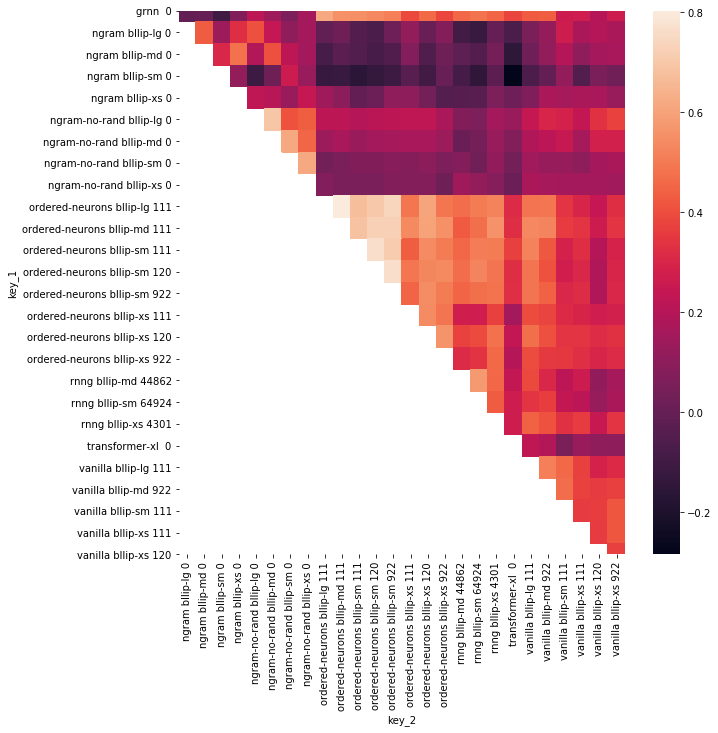

In [26]:
plt.subplots(figsize=(10, 10))
sns.heatmap(data=corr_df.pivot("key_1", "key_2", "corr"))

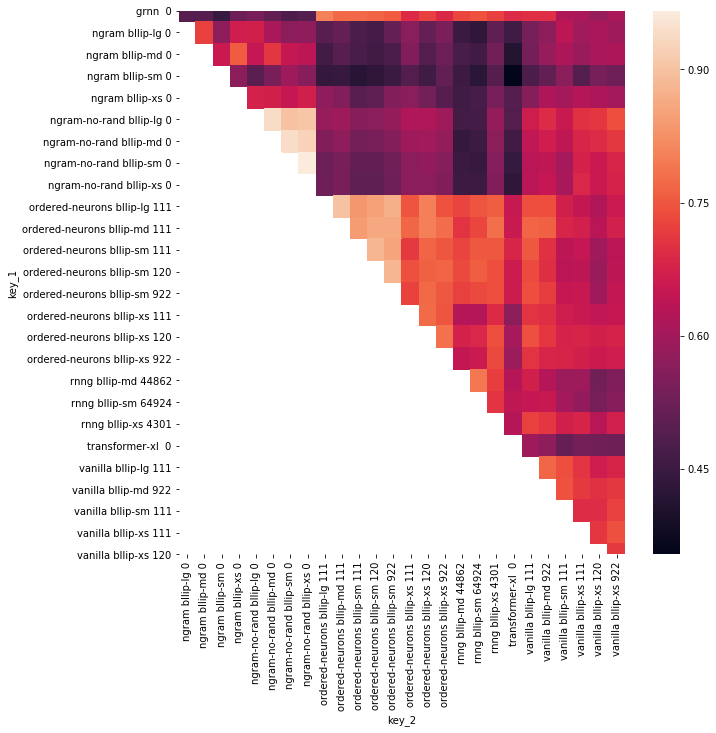

In [27]:
plt.subplots(figsize=(10, 10))
sns.heatmap(data=agree_df.pivot("key_1", "key_2", "agreement"))

Text(0.5, 1.0, 'Distribution of item-level accuracy means')

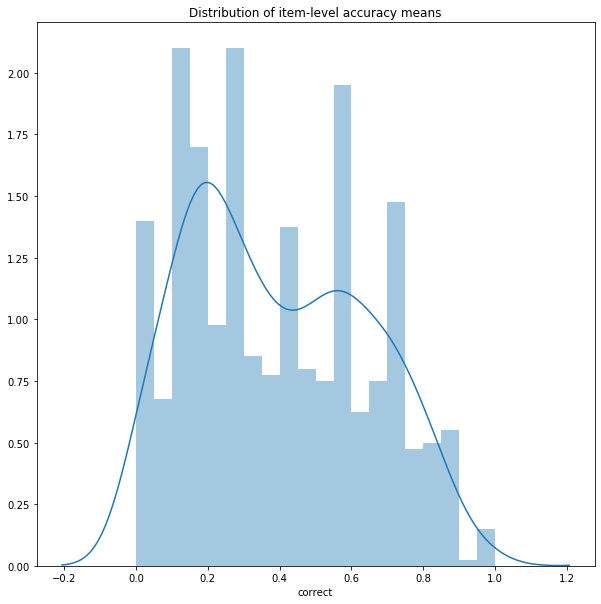

In [28]:
plt.subplots(figsize=(10, 10))
sns.distplot(results_df.groupby(["suite", "item"]).correct.agg("mean"), bins=20)
plt.title("Distribution of item-level accuracy means")

Text(0.5, 1.0, 'Distribution of item-level accuracy stdevs')

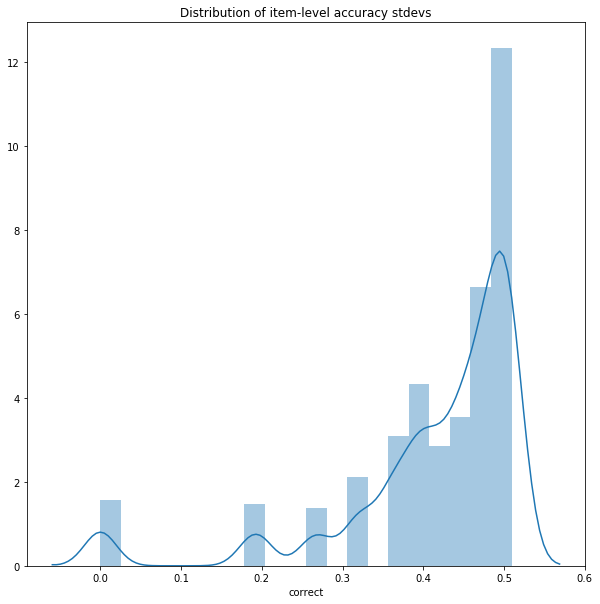

In [29]:
plt.subplots(figsize=(10, 10))
sns.distplot(results_df.groupby(["suite", "item"]).correct.agg("std"), bins=20)
plt.title("Distribution of item-level accuracy stdevs")

Text(0.5, 1.0, 'Distribution of suite-level accuracy means')

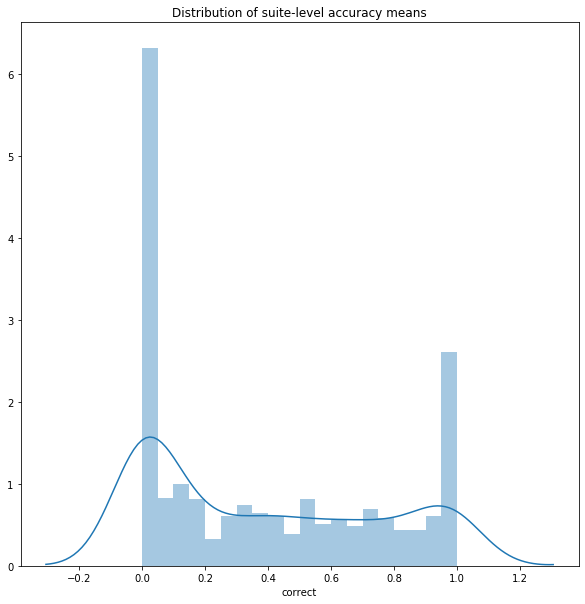

In [30]:
plt.subplots(figsize=(10, 10))
sns.distplot(suites_df.correct, bins=20)
plt.title("Distribution of suite-level accuracy means")

### Variance in accuracy vs variance in perplexity

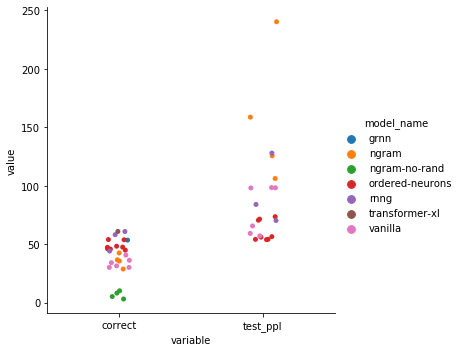

In [31]:
catplot_ticks = ["correct", "test_ppl"]
catplot_data = joined_data.copy()
catplot_data["correct"] *= 100
catplot_data = catplot_data.melt(id_vars=set(catplot_data.columns) - set(catplot_ticks))
# catplot_data["corpus_size"] = catplot_data.corpus.map(corpus_to_size)

g = sns.catplot(data=catplot_data,
                x="variable", y="value", hue="model_name")

### Circuit–circuit correlations

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 0.98, 'Circuit--circuit correlations')

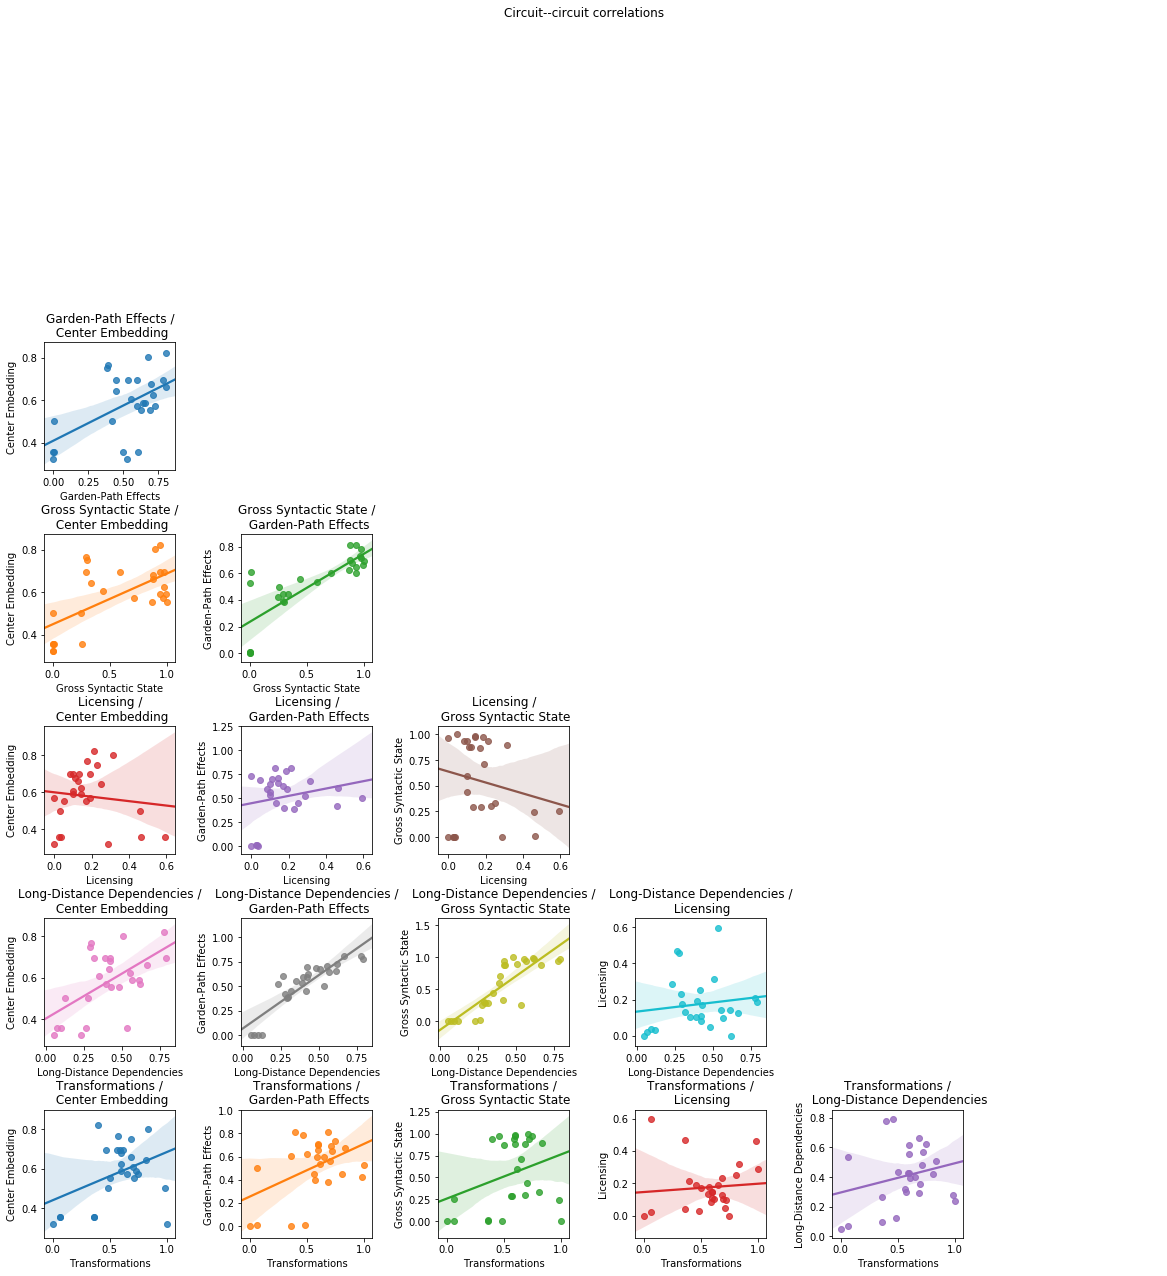

In [32]:
f, axs = plt.subplots(len(circuit_order), len(circuit_order), figsize=(20, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

for c1, row in zip(circuit_order, axs):
    for c2, ax in zip(circuit_order, row):
        if c1 <= c2:
            ax.axis("off")
            continue
            
        xs = results_df[results_df.circuit == c1].groupby(["model_name", "corpus", "seed"]).correct.agg({c1: "mean"})
        ys = results_df[results_df.circuit == c2].groupby(["model_name", "corpus", "seed"]).correct.agg({c2: "mean"})
        df = pd.concat([xs, ys], axis=1)
        ax.set_title("%s /\n %s" % (c1, c2))
        sns.regplot(data=df, x=c1, y=c2, ax=ax)
        
plt.suptitle("Circuit--circuit correlations")

### Stability to modification

Text(0.5, 1.0, 'Stability to modification')

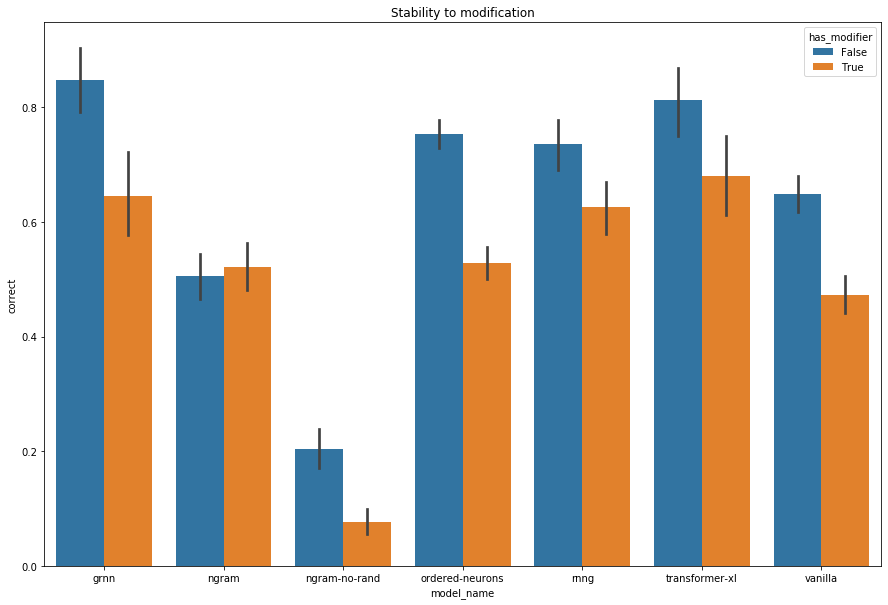

In [33]:
plt.subplots(figsize=(15, 10))
sns.barplot(data=results_df_mod, x="model_name", y="correct", hue="has_modifier")
plt.title("Stability to modification")

Text(0.5, 1.0, 'Stability to modification')

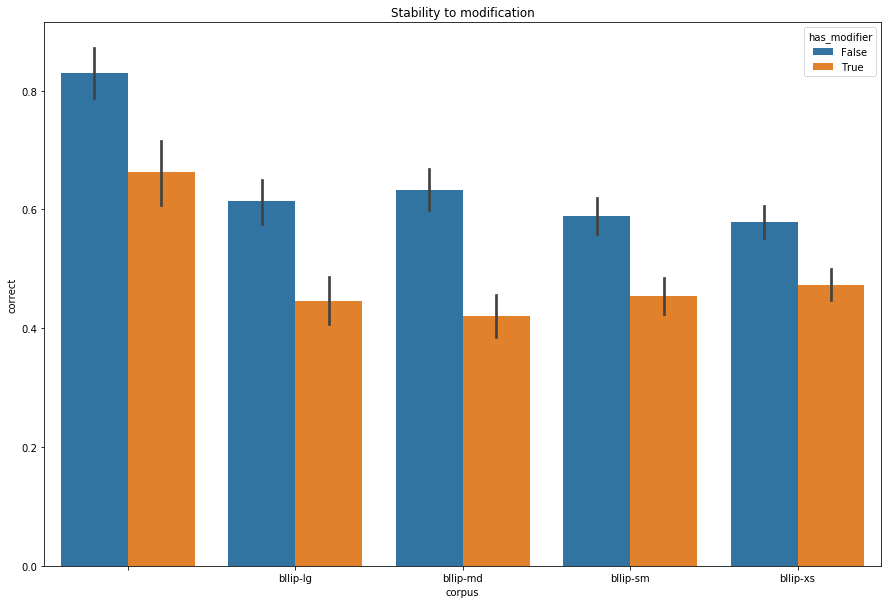

In [34]:
plt.subplots(figsize=(15, 10))
sns.barplot(data=results_df_mod, x="corpus", y="correct", hue="has_modifier")
plt.title("Stability to modification")

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


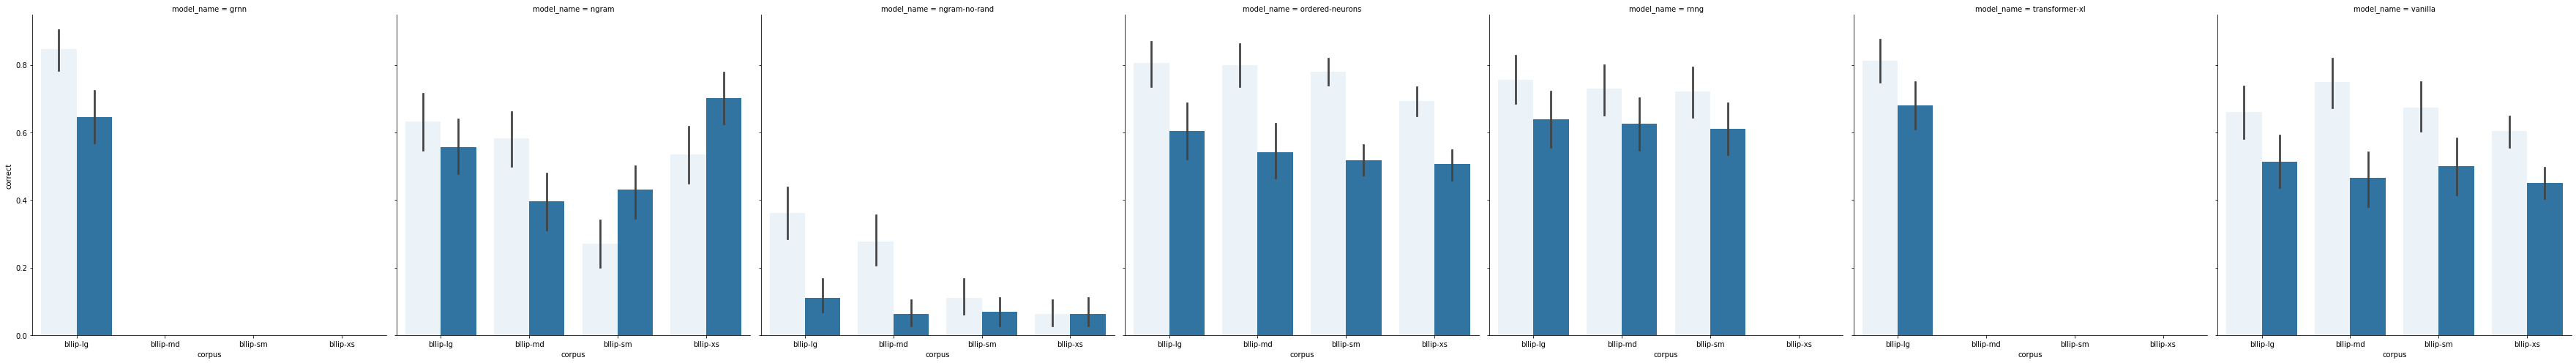

In [35]:
g = sns.FacetGrid(data=results_df_mod, col="model_name", height=7)
g.map(sns.barplot, "corpus", "correct", "has_modifier")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Change in accuracy due to modification')

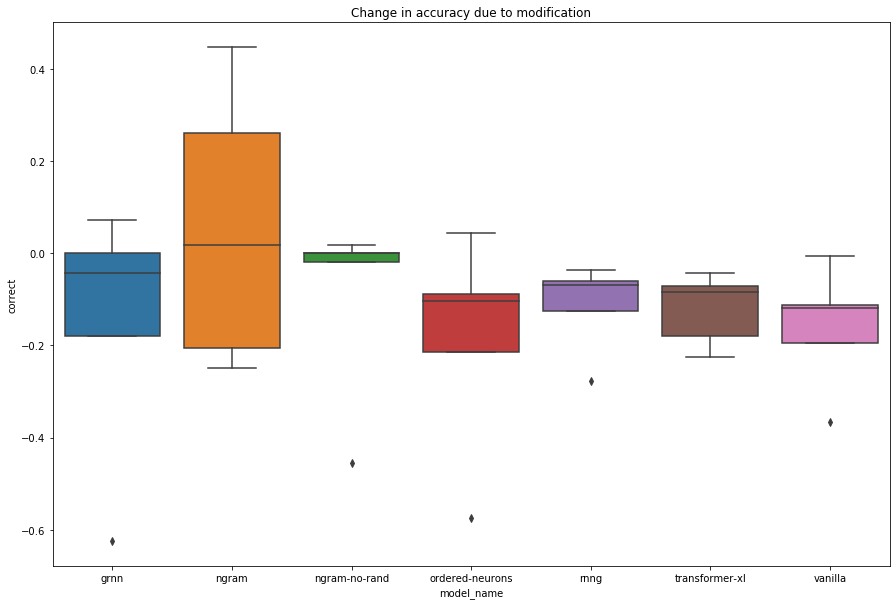

In [36]:
avg_mod_results = results_df_mod.groupby(["model_name", "test_suite_base", "has_modifier"]).correct.agg({"correct": "mean"}).sort_index()
avg_mod_diffs = avg_mod_results.xs(True, level="has_modifier") - avg_mod_results.xs(False, level="has_modifier")

plt.subplots(figsize=(15, 10))
sns.boxplot(data=avg_mod_diffs.reset_index(), x="model_name", y="correct")
plt.title("Change in accuracy due to modification")